In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import efficient_frontier
from pypfopt import objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [3]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import yfinance as yfin
yfin.pdr_override()

def _load_prices(
    ticker: str,
    data_source: str = 'yahoo',
    end: str = datetime.date.today()
) -> pd.DataFrame:
    return pdr.get_data_yahoo(ticker, start='2000-01-01', end=end).loc[:, 'Adj Close']

def load_prices_multitickers(
    tickers: list,
    data_source: str = 'yahoo',
    end: str = datetime.date.today()
) -> list:
    prices = pd.DataFrame()
    for t in tickers:
        prices[t] = _load_prices(t, data_source, end)
        
    return prices.fillna(value=None, method="ffill", axis=0, inplace=False).dropna(axis=0, how='any', inplace=False)

In [4]:
def calc_omega(views):
    variances = []
    for symbol, view in views.items():
        lb, ub  = view[0], view[2]
        std_dev = (ub - lb)/2
        variances.append(std_dev ** 2)
    omega = np.diag(variances)
    return omega

def load_mean_views(views):
    mu = {}
    for symbol, view in views.items():
        mu[symbol] = view[1]
    return mu

In [5]:
def load_gdp_data(fname: str) -> pd.DataFrame:
    world_gdp = pd.read_csv(
        fname, 
        sep=",", 
        header=2,
        index_col="Country Code", 
        #names=["Date", "mkt"], 
        skipinitialspace=True,
        skip_blank_lines=True,
        parse_dates=True,
        infer_datetime_format=True
    ).loc["WLD"].iloc[3:].dropna().astype('float64').reset_index()
    
    world_gdp.loc[:, 'index'] = pd.to_datetime(world_gdp.loc[:, 'index'])
    return world_gdp.set_index('index')

def interpolate_gdp_data(df_gdp : pd.DataFrame) -> pd.DataFrame:
    temp = pd.DataFrame(
        pd.date_range(start=g.index[0], end=g.index[-1], freq='D'),
        columns=["date"]
    )
    temp.loc[:, 'dmy'] = math.nan
    i_gdp = temp.set_index('date').join(df_gdp).drop('dmy', axis=1).interpolate(method = 'akima', axis=0)
    
    return i_gdp

In [6]:
tickers = ['VOO', 'BND', 'VXUS', 'BNDX']
prices=load_prices_multitickers(tickers, 'yahoo')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
msci = pd.read_csv("./data/msci.csv", sep=",", header=0, index_col="Date", names=["Date", "mkt"], skipinitialspace=True, skip_blank_lines=True, parse_dates=True, infer_datetime_format=True, thousands=",")
msci

,mkt
Date,
1994-05-31,392.682
1994-06-30,392.593
1994-07-29,398.298
1994-08-31,410.747
1994-09-30,400.733
...,...
2023-08-31,1732.630
2023-09-29,1657.168
2023-10-31,1600.928


In [8]:
g = load_gdp_data("./data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4251000.csv")
g = pd.DataFrame(interpolate_gdp_data(g).join(prices).dropna(axis=0, how='any', inplace=False).loc[:, "WLD"].rename("mkt"))
g

,mkt
date,
2013-06-04,7.849682e+13
2013-06-05,7.850259e+13
2013-06-06,7.850835e+13
2013-06-07,7.851412e+13
2013-06-10,7.853141e+13
...,...
2020-12-24,9.570453e+13
2020-12-28,9.590192e+13
2020-12-29,9.595139e+13


In [9]:
rets = {}
covs = {}

In [10]:
risk_free_rate=1.005**((1/252)) - 1
risk_free_rate

1.9792027252663047e-05

In [11]:
rets['mhr'] = expected_returns.mean_historical_return(prices, frequency=252)
rets['ehr'] = expected_returns.ema_historical_return(prices, frequency=252, span=252*5)
rets['capmr'] = expected_returns.capm_return(prices,  risk_free_rate=risk_free_rate, compounding=True, frequency=252)

In [12]:
covs['sample_cov'] = risk_models.risk_matrix(prices, method='sample_cov')
covs['semicovariance'] = risk_models.risk_matrix(prices, method='semicovariance', benchmark=risk_free_rate, frequency=252, log_returns=False)
covs['exp_cov'] = risk_models.risk_matrix(prices, method='exp_cov', span=252*5, frequency=252)

In [13]:
covs['ledoiid_wolf_cc'] = risk_models.risk_matrix(prices, method='ledoit_wolf_constant_correlation', frequency=252)
covs['ledoiid_wolf_sf'] = risk_models.risk_matrix(prices, method='ledoit_wolf_single_factor', frequency=252)
covs['ledoiid_wolf_cv'] = risk_models.risk_matrix(prices, method='ledoit_wolf_constant_variance', frequency=252)
covs['oracle_approx'] = risk_models.risk_matrix(prices, method='oracle_approximating', frequency=252)

In [14]:
rets

{'mhr': VOO     0.127043
 BND     0.016431
 VXUS    0.049026
 BNDX    0.022297
 dtype: float64,
 'ehr': VOO     0.149110
 BND     0.005717
 VXUS    0.073422
 BNDX    0.011765
 Name: 2023-12-29 00:00:00, dtype: float64,
 'capmr': VOO     0.105806
 BND     0.011185
 VXUS    0.103781
 BNDX    0.007743
 Name: mkt, dtype: float64}

In [15]:
covs

{'sample_cov':            VOO       BND      VXUS      BNDX
 VOO   0.030314  0.000849  0.025648  0.000631
 BND   0.000849  0.002687  0.001066  0.001461
 VXUS  0.025648  0.001066  0.029065  0.000564
 BNDX  0.000631  0.001461  0.000564  0.001538,
 'semicovariance':            VOO       BND      VXUS      BNDX
 VOO   0.015523  0.001756  0.013816  0.001325
 BND   0.001756  0.001406  0.001896  0.000829
 VXUS  0.013816  0.001896  0.015742  0.001360
 BNDX  0.001325  0.000829  0.001360  0.000782,
 'exp_cov':            VOO       BND      VXUS      BNDX
 VOO   0.035455  0.002438  0.028426  0.001599
 BND   0.002438  0.004405  0.002553  0.002724
 VXUS  0.028426  0.002553  0.031004  0.001441
 BNDX  0.001599  0.002724  0.001441  0.002619,
 'ledoiid_wolf_cc':            VOO       BND      VXUS      BNDX
 VOO   0.030314  0.000882  0.025401  0.000656
 BND   0.000882  0.002687  0.001095  0.001449
 VXUS  0.025401  0.001095  0.029065  0.000589
 BNDX  0.000656  0.001449  0.000589  0.001538,
 'ledoiid_wolf

In [16]:
mcaps = {
    'VOO': 52370474000000.01,
    'BND': 49000000000000,
    'VXUS': 41315525999999.99,
    'BNDX': 70000000000000
}
mcaps

{'VOO': 52370474000000.01,
 'BND': 49000000000000,
 'VXUS': 41315525999999.99,
 'BNDX': 70000000000000}

In [17]:
delta = black_litterman.market_implied_risk_aversion(g.iloc[:-365, 0], frequency=252, risk_free_rate=0.005)
delta

844.8011584382269

In [18]:
delta1 = black_litterman.market_implied_risk_aversion(prices["VOO"][:-252*3], frequency=252, risk_free_rate=0.005)
delta2 = black_litterman.market_implied_risk_aversion(prices["BND"][:-252*3], frequency=252, risk_free_rate=0.005)
delta3 = black_litterman.market_implied_risk_aversion(prices["VXUS"][:-252*3], frequency=252, risk_free_rate=0.005)
delta4 = black_litterman.market_implied_risk_aversion(prices["BNDX"][:-252*3], frequency=252, risk_free_rate=0.005)
print(delta1, delta2, delta3, delta4)
delta=delta1

4.598512213815003 15.944247493852936 2.2834567604302896 37.640899608796914


In [19]:
delta = black_litterman.market_implied_risk_aversion(msci.iloc[:, 0], frequency=12, risk_free_rate=0.005)
delta

2.450249865843789

In [20]:
viewdict = {
    "VOO":[0.02, 0.07, 0.09],
    "BND":[0.0, 0.015, 0.02],
    "VXUS":[0.01, 0.04, 0.07],
    "BNDX":[-0.01, 0.015, 0.02]
}
omega = calc_omega(viewdict)
mu = load_mean_views(viewdict)

In [21]:
cov_matrix = covs['oracle_approx']
bl = BlackLittermanModel(cov_matrix, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views=mu, omega=omega)
rets['bl_post'] = bl.bl_returns()
covs['bl_post'] = bl.bl_cov()
rets

{'mhr': VOO     0.127043
 BND     0.016431
 VXUS    0.049026
 BNDX    0.022297
 dtype: float64,
 'ehr': VOO     0.149110
 BND     0.005717
 VXUS    0.073422
 BNDX    0.011765
 Name: 2023-12-29 00:00:00, dtype: float64,
 'capmr': VOO     0.105806
 BND     0.011185
 VXUS    0.103781
 BNDX    0.007743
 Name: mkt, dtype: float64,
 'bl_post': VOO     0.050627
 BND     0.011306
 VXUS    0.045126
 BNDX    0.008133
 dtype: float64}

In [22]:
r = 0.04
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix, weight_bounds=(0.05, 0.6))
ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
#w = ef_bl.max_sharpe(risk_free_rate=0.005)
w = ef_bl.efficient_return(r)
perf_bst = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_bst)

Expected annual return: 4.0%
Annual volatility: 13.4%
Sharpe Ratio: 0.26
OrderedDict([('VOO', 0.4167205860221028), ('BND', 0.118035994024291), ('VXUS', 0.3726201194524268), ('BNDX', 0.0926233005011794)])
(0.04, 0.1335283083582733, 0.2621167034191026)


In [23]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix, weight_bounds=(0.05, 0.6))
ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
w = ef_bl.max_sharpe(risk_free_rate=0.005)
perf_mshL2 = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_mshL2)

Expected annual return: 4.4%
Annual volatility: 14.9%
Sharpe Ratio: 0.26
OrderedDict([('VOO', 0.4711938729536276), ('BND', 0.0667576052271107), ('VXUS', 0.4120485218192616), ('BNDX', 0.05)])
(0.04361070731797961, 0.14861077886203802, 0.25981094785744746)


/root/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [24]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)
w = ef_bl.max_sharpe(risk_free_rate=0.005)
perf_msh = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_msh)

Expected annual return: 2.8%
Annual volatility: 8.5%
Sharpe Ratio: 0.28
OrderedDict([('VOO', 0.4003719590686772), ('BND', 0.55689003408922), ('VXUS', 0.0427380068421028), ('BNDX', 0.0)])
(0.028494232988695044, 0.08460529093231653, 0.27769224276399235)


In [25]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

min_ret = max(0, min(expected_return))
max_ret = min(0.25, max(expected_return))
rets_seq = list(np.arange(min_ret, max_ret, 0.001))

weights = {}
max_sr = -1
max_r = 0.0
for r in rets_seq:
    _ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)
    _ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
    _w = _ef_bl.efficient_return(r)
    _perf = _ef_bl.portfolio_performance(verbose=False, risk_free_rate=0.005)
    
    weights[r] = (_perf, _w)
    
    if _perf[2] >= max_sr:
        max_sr = _perf[2]
        max_r = r
print("{0}:{1}".format(max_r, max_sr))
print(weights[max_r])

0.028132557626604514:0.2687791948458463
((0.028310592986461804, 0.08672766878340861, 0.2687791948458463), OrderedDict([('VOO', 0.2434962768315132), ('BND', 0.2561289841327463), ('VXUS', 0.2437736545033764), ('BNDX', 0.2566010845323641)]))


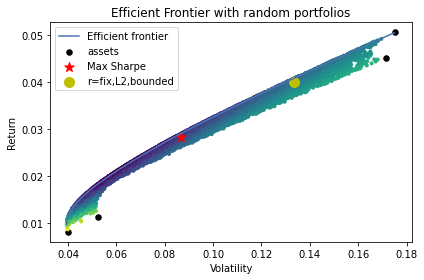

In [26]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_for_plot = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plot, ax=ax, show_assets=True)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(expected_return)), n_samples)
r = w.dot(expected_return)
s = np.sqrt(np.diag(w @ cov_matrix @ w.T))
sharpes = r / s
ax.scatter(s, r, marker=".", c=sharpes, cmap="viridis_r")

ret_tangent, std_tangent, _ = weights[max_r][0]
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ret_bst, std_bst, _ = perf_bst
ax.scatter(std_bst, ret_bst, marker="o", s=100, c="y", label="r=fix,L2,bounded")

ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [135]:
from sklearn.model_selection import TimeSeriesSplit

In [111]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=252*5, test_size=252, gap=0)
for train, test in tscv.split(prices):
    print(prices.iloc[train, :])
    print("\n")

                   VOO        BND       VXUS       BNDX
Date                                                   
2015-01-13  159.647644  67.771652  37.904896  44.576054
2015-01-14  158.708801  67.926086  37.746292  44.684330
2015-01-15  157.227310  68.226822  38.015907  44.476151
2015-01-16  159.173920  68.023613  38.388618  44.734303
2015-01-20  159.570145  67.950439  38.436195  44.717632
...                ...        ...        ...        ...
2020-01-08  283.903381  78.317558  51.109058  53.276764
2020-01-09  285.865570  78.410828  51.338451  53.286171
2020-01-10  285.046417  78.541389  51.274227  53.380138
2020-01-13  286.932404  78.494759  51.659607  53.267361
2020-01-14  286.551361  78.606682  51.668781  53.295559

[1260 rows x 4 columns]


                   VOO        BND       VXUS       BNDX
Date                                                   
2016-01-13  152.268860  67.825180  33.962173  45.023346
2016-01-14  154.740540  67.741852  34.418156  44.879463
2016-01-15  151.42446